<a href="https://colab.research.google.com/github/Nathan-Nicolau/RedesNeuraisTCC/blob/main/Modelo_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Aplicando modelo de CNN InceptionV3 para detecção de imagens
#link do dataset utilizado do Kaggle : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code

#adição da chave de API para download do dataset de teste dessa rede, direto do Kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Usuário Nathan fez o upload "{name}" com o tamanho de {length} bytes.'.format(name=fn,length=len(uploaded[fn])))

#Movendo local da chave de API
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
Usuário Nathan fez o upload "kaggle.json" com o tamanho de 69 bytes.


In [2]:
#Dowload do dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 99% 15.0M/15.1M [00:01<00:00, 20.6MB/s]
100% 15.1M/15.1M [00:01<00:00, 11.9MB/s]


In [3]:
#Descompactando
from zipfile import ZipFile
nome_arquivo = "/content/brain-mri-images-for-brain-tumor-detection.zip"

with ZipFile(nome_arquivo,'r') as zip:
  zip.extractall()
  print("Dataset descompactado")

Dataset descompactado


In [4]:
#Criação do modelo da CNN
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

<ipython-input-4-bef374af7a1b>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [5]:
os.chdir('/content/yes')
x = []
y = []
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
  y.append((i[0:1]))
os.chdir('/content/no')

for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img,(224,224))
  x.append(img)
for i in range(1,99):
  y.append('N')

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(x,y, test_size=0.33, random_state=42)
print("Shape of an image in x_train: ",x_train[0].shape)
print("Shape of an image in x_test: ",x_test[0].shape)

Shape of an image in x_train:  (224, 224, 3)
Shape of an image in x_test:  (224, 224, 3)


In [7]:
import numpy as np
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train,num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=2)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test)

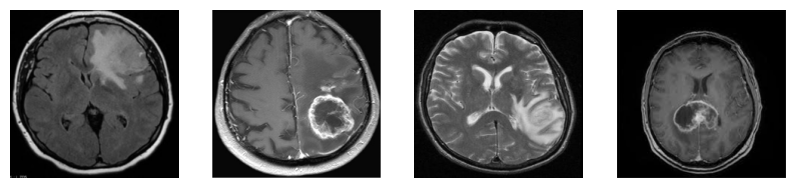

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(x[i],cmap='gray')
  plt.axis('off')
plt.show()

In [9]:
#InceptionV3 do Keras
from keras.applications import InceptionV3

img_linhas, img_colunas = 224,224

rede = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(img_linhas,img_colunas,3))

for layer in rede.layers:
  layer.trainable = False

for (i,layer) in enumerate(rede.layers):
  print(str(i) + " "+ layer.__class__.__name__,layer.trainable)

87910968/87910968 [==============================] - 4s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44

In [10]:
from keras.src.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras import regularizers

def lw(bottom_model,num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01))(top_model)
  top_model = Dense(num_classes,activation='softmax')(top_model)
  return top_model

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from tensorflow.keras.layers import Input

num_classes = 2
FC_head = lw(rede,num_classes)

model = Model(inputs = rede.input, outputs = FC_head)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0